Example of how to cluster HSNE hierarchies using Louvain clustering


Most of these dependencies are standard toolkit for data scientists

Not so standard:
igraph: https://igraph.org/

good implementation of louvain algorithm: https://louvain-igraph.readthedocs.io/en/latest/install.html


In [1]:
from HSNE_parser import read_HSNE_binary
import pandas as pd
import numpy as np
import igraph as ig
import louvain

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import rcParams

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix


In [7]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    from matplotlib.ticker import StrMethodFormatter
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [10]:
rcParams['figure.figsize'] = 40, 20
def draw_contingency_heatmap(labels_pred, labels_true):
    cont_mat = contingency_matrix(labels_pred=labels_pred, labels_true=labels_true)
#     sum_of_rows = np.sum(cont_mat, axis=1)
#     cont_mat = np.hstack((cont_mat, sum_of_rows.reshape((cont_mat.shape[0] ,1))))
#     sum_of_cols = np.sum(cont_mat, axis=0)
#     cont_mat = np.vstack((cont_mat, sum_of_cols))
    #cont_mat = np.round(normalize(cont_mat, norm='l1', axis=1), 2)
    fig, ax = plt.subplots()

    im, cbar = heatmap(cont_mat, row_labels=list(np.unique(labels_true)),
                       col_labels=list(np.unique(labels_pred)),
                       ax=ax,
                       cmap="YlGn", cbarlabel="Count")
    texts = annotate_heatmap(im, valfmt="{x}")
    ax.tick_params(labelsize="xx-large")
    fig.tight_layout()
    plt.show()

Read the hierarchy from a HSNE binary file and print progress:

In [4]:
def run_louvain(tmatrix, **kwargs):
    weighted = kwargs['weight']
    sources, targets = tmatrix.nonzero()
    edgelist = list(zip(sources.tolist(), targets.tolist()))
    G = ig.Graph(edgelist)
    if weighted:
        G.es['weight'] = tmatrix.data
        return louvain.find_partition(G, louvain.ModularityVertexPartition, weights=G.es['weight']).membership
    else:
        return louvain.find_partition(G, louvain.ModularityVertexPartition).membership


In [2]:
hsne = read_HSNE_binary(filename="/home/paul/Stage/LDA/Data/MNIST/mnist_no_labels_train.hsne", verbose=True)

Number of scales 4
Start reading first scale of size 60000
Done reading first scale..

Next scale: 1
Scale size: 12005
Reading transmatrix..
Reading landmarks of scale to original data..
Reading landmarks to previous scale..
Reading landmark weights..
Reading previous scale to current scale..
Reading area of influence..
Time spent converting reading AOI: 3.348859
Time spent converting 1D to sparse: 2.243680

Next scale: 2
Scale size: 1765
Reading transmatrix..
Reading landmarks of scale to original data..
Reading landmarks to previous scale..
Reading landmark weights..
Reading previous scale to current scale..
Reading area of influence..
Time spent converting reading AOI: 0.747475
Time spent converting 1D to sparse: 0.515796

Next scale: 3
Scale size: 128
Reading transmatrix..
Reading landmarks of scale to original data..
Reading landmarks to previous scale..
Reading landmark weights..
Reading previous scale to current scale..
Reading area of influence..
Time spent converting reading A

Fetch raw MNIST data & labels

MNIST in CSV format available at: https://pjreddie.com/projects/mnist-in-csv/

In [3]:
# Read mnist data and put labels in seperate array
mnist = pd.read_csv("/home/paul/Stage/LDA/Data/MNIST/mnist_train.csv", header=None)
mnist_data = mnist.drop(columns=0)
mnist_labels = mnist[0].ravel()
del mnist

MNIST are handwritten digits 0-9 with each pixel corresponding to a grey value

Label: 5


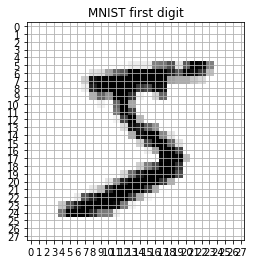

In [10]:
rcParams['figure.figsize'] = 4, 4
# Invert grey values for imshow()
inverted = np.array(np.asarray([255] * len(mnist_data.iloc[0])) - mnist_data.iloc[0])
plt.imshow(inverted.reshape(28, 28), cmap='gray')
plt.xticks([i for i in range(28)])
plt.yticks([i for i in range(28)])
plt.grid(b=True)
plt.title("MNIST first digit")
print("Label: %s" % (mnist_labels[0]))
plt.show()

Louvain Clustering on HSNE scale 2, 1765 datapoints:

note that Louvain clustering can take long on very large matrices (transition matrices of say, 200k * 200k or larger)

In [45]:
# Find the commmunity assignments that give highest modularity
clusters = run_louvain(hsne[1].tmatrix, weight=True)

In [47]:
# 11 clusters are found
set(clusters)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

In [48]:
# List where index is landmark on scale and value is cluster assignment
clusters

[12,
 4,
 9,
 0,
 12,
 7,
 2,
 0,
 4,
 7,
 12,
 6,
 4,
 7,
 8,
 3,
 1,
 8,
 4,
 9,
 1,
 9,
 7,
 0,
 1,
 0,
 4,
 4,
 6,
 3,
 4,
 0,
 2,
 7,
 0,
 6,
 7,
 8,
 3,
 3,
 4,
 6,
 2,
 0,
 1,
 5,
 4,
 0,
 3,
 5,
 7,
 2,
 8,
 11,
 11,
 7,
 10,
 0,
 3,
 1,
 7,
 4,
 8,
 7,
 4,
 2,
 1,
 1,
 11,
 6,
 5,
 0,
 4,
 5,
 4,
 8,
 7,
 7,
 5,
 8,
 5,
 0,
 1,
 4,
 10,
 7,
 5,
 2,
 7,
 7,
 5,
 7,
 5,
 0,
 2,
 12,
 3,
 7,
 6,
 6,
 0,
 1,
 7,
 6,
 0,
 2,
 0,
 0,
 3,
 2,
 4,
 3,
 7,
 0,
 8,
 3,
 5,
 6,
 10,
 0,
 3,
 12,
 4,
 4,
 1,
 6,
 5,
 3,
 0,
 1,
 6,
 0,
 5,
 1,
 7,
 0,
 1,
 8,
 12,
 8,
 3,
 6,
 2,
 0,
 10,
 3,
 1,
 1,
 1,
 9,
 3,
 5,
 5,
 2,
 5,
 1,
 6,
 1,
 7,
 2,
 3,
 5,
 4,
 9,
 1,
 5,
 8,
 5,
 8,
 4,
 5,
 2,
 1,
 8,
 0,
 8,
 4,
 2,
 1,
 1,
 0,
 1,
 4,
 5,
 3,
 2,
 9,
 3,
 12,
 4,
 1,
 0,
 8,
 4,
 6,
 1,
 3,
 2,
 1,
 8,
 1,
 1,
 6,
 6,
 0,
 5,
 11,
 4,
 6,
 8,
 8,
 1,
 8,
 6,
 11,
 6,
 2,
 1,
 4,
 3,
 5,
 12,
 1,
 1,
 8,
 12,
 0,
 1,
 6,
 7,
 6,
 12,
 11,
 8,
 8,
 3,
 1,
 7,
 5,
 0,
 12,
 7,
 6,
 3,
 12

Calculate rand index of clustering versus labels:

In [51]:
landmark_truth = mnist_labels[np.array(hsne[1].lm_to_original)]
adjusted_rand_score(clusters, landmark_truth)

0.9070790890576844

Clustering is good; contingency matrix of clustering:

1's are split into 2 clusters of respectively 170 and 120 landmarks

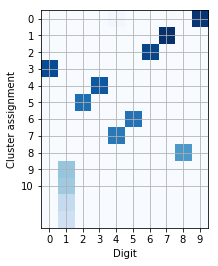

In [52]:
plt.imshow(contingency_matrix(list(clusters), landmark_truth), cmap='Blues')
plt.xticks([i for i in range(10)])
plt.yticks([ i for i in range(11)])
plt.ylabel("Cluster assignment")
plt.xlabel("Digit")
plt.grid(b=True)
plt.show()

Why are the 1's split into more clusters? 

Inspection of the average values of each cluster shows that the clustering discerns between slanted and straight 1's, the straight ones might even contain some left slanted 1's.

In [54]:
mask1 = np.array(clusters) == 9
mask2 = np.array(clusters) == 10
landmarks1 = np.array(hsne[1].lm_to_original)[mask1]
landmarks2 = np.array(hsne[1].lm_to_original)[mask2]

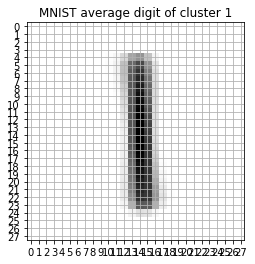

In [55]:
sum(mnist_data.iloc[landmarks1].values) / len(landmarks1)
rcParams['figure.figsize'] = 4, 4
# Invert grey values for imshow()

inverted = np.array(np.asarray([255] * len(mnist_data.iloc[0])) - sum(mnist_data.iloc[landmarks1].values) / len(landmarks1))
plt.imshow(inverted.reshape(28, 28), cmap='gray')
plt.xticks([i for i in range(28)])
plt.yticks([i for i in range(28)])
plt.grid(b=True)
plt.title("MNIST average digit of cluster 1")
plt.show()

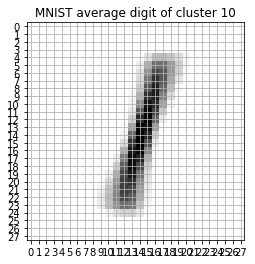

In [56]:
sum(mnist_data.iloc[landmarks2].values) / len(landmarks2)
rcParams['figure.figsize'] = 4, 4
# Invert grey values for imshow()

inverted = np.array(np.asarray([255] * len(mnist_data.iloc[0])) - sum(mnist_data.iloc[landmarks2].values) / len(landmarks1))
plt.imshow(inverted.reshape(28, 28), cmap='gray')
plt.xticks([i for i in range(28)])
plt.yticks([i for i in range(28)])
plt.grid(b=True)
plt.title("MNIST average digit of cluster 10")
plt.show()

# For how to propagate clustering of a scale back to each original datapoint, see the Markov clustering example notebook in this repository